In [1]:
!gdown --id 1pm50hZr3nLy0aYlsv88iXpJRkdm_NxM1
!unzip financial-news-data.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pm50hZr3nLy0aYlsv88iXpJRkdm_NxM1
To: /content/financial-news-data.zip
100% 952k/952k [00:00<00:00, 10.6MB/s]
Archive:  financial-news-data.zip
  inflating: financial-news-test.csv  
  inflating: __MACOSX/._financial-news-test.csv  
  inflating: financial-news-train.csv  
  inflating: __MACOSX/._financial-news-train.csv  


# Preparation

## Load data

In [50]:
import pandas as pd

train_df = pd.read_csv("/content/financial-news-train.csv")
test_df = pd.read_csv("/content/financial-news-test.csv")

train_df.head(5)

,text,label
0,Here are Thursday's biggest analyst calls: App...,Analyst Update
1,Buy Las Vegas Sands as travel to Singapore bui...,Analyst Update
2,"Piper Sandler downgrades DocuSign to sell, cit...",Analyst Update
3,"Analysts react to Tesla's latest earnings, bre...",Analyst Update
4,Netflix and its peers are set for a ‘return to...,Analyst Update


## Info of each set of data

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16990 entries, 0 to 16989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16990 non-null  object
 1   label   16990 non-null  object
dtypes: object(2)
memory usage: 265.6+ KB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4117 entries, 0 to 4116
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4117 non-null   object
 1   label   4117 non-null   object
dtypes: object(2)
memory usage: 64.5+ KB


## Explore data

In [14]:
train_df['label'].unique()

array(['Analyst Update', 'Company | Product News',
       'General News | Opinion', 'Currencies', 'Dividend', 'Earnings',
       'Energy | Oil', 'Fed | Central Banks', 'Financials',
       'Gold | Metals | Materials', 'IPO', 'Legal | Regulation',
       'M&A | Investments', 'Macro', 'Markets', 'Personnel Change',
       'Politics', 'Stock Commentary', 'Stock Movement',
       'Treasuries | Corporate Debt'], dtype=object)

In [15]:
train_df['label'].value_counts()

,count
label,
Company | Product News,3545
Stock Commentary,2118
Macro,1822
General News | Opinion,1557
Earnings,987
Politics,985
Fed | Central Banks,837
Stock Movement,823
Financials,624


In [16]:
test_df['label'].value_counts()

,count
label,
Company | Product News,852
Stock Commentary,528
Macro,415
General News | Opinion,336
Politics,249
Earnings,242
Fed | Central Banks,214
Stock Movement,197
Financials,160


## Preprocess data

### Train set

note: 
* `CountVectorizer()` creates a "bag of words" representation.
* `vectorizer.fit_transform()` learn vocab & params from data -> transform data into a numerical feature matrix
    1. `fit()` learn vocab & params from data
    2. `transform()` use params -> sparse matrix e.g. bag of words table
    
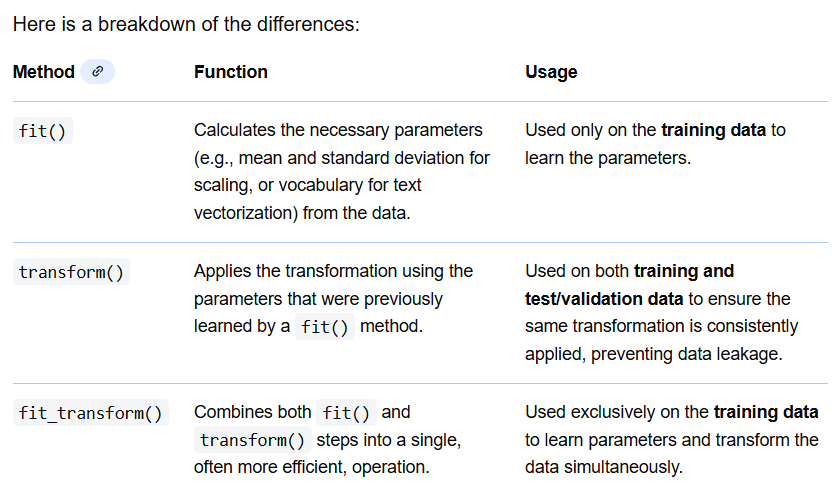 

### Test set

In [115]:
import pandas as pd

test_df = test_df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=6, random_state=42))
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 4 to 4087
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    120 non-null    object
 1   label   120 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB


/tmp/ipython-input-1575039006.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=6, random_state=42))


In [116]:
test_df['label'].value_counts()

,count
label,
Analyst Update,6
Company | Product News,6
Currencies,6
Dividend,6
Earnings,6
Energy | Oil,6
Fed | Central Banks,6
Financials,6
General News | Opinion,6


In [117]:
test_df.tail()

,text,label
4075,PEPSICO ISSUES NEW $1.25 BILLION 10-YEAR GREEN...,Treasuries | Corporate Debt
4050,$SLCA: U.S. Silica completes $100 mln voluntar...,Treasuries | Corporate Debt
4040,Treasury yields have risen sharply recently. I...,Treasuries | Corporate Debt
4085,US Corporate Debt Issuance To Weaken As Rates ...,Treasuries | Corporate Debt
4087,Bond Investors Bet The Recession Trade Is Just...,Treasuries | Corporate Debt


# Logistic Regression

## Create Data Pipeline

In [142]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import string
import re

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words_list = stopwords.words('english')

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        self.punctuation = string.punctuation

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(self._process_text)
    
    def _process_text(self, text):
        # Delete URLs
        text = re.sub(r'https?://\S+|www\.\S+|t\.co/\S+', '', text)

        # Delete Punctuation
        # text = text.translate(str.maketrans('', '', self.punctuation))

        # Tokenize and Lemmatize
        tokens = word_tokenize(text.lower())
        lemmatized = [self.lemmatizer.lemmatize(word) for word in tokens]

        return " ". join(lemmatized)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [143]:
model_pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('vectorizer', CountVectorizer(stop_words=stop_words_list)),
    ('classifier', LogisticRegression(
        max_iter=1000, 
        class_weight='balanced'
    ))
])

In [144]:
model_pipeline.fit(train_df['text'], train_df['label'])

Pipeline(steps=[('cleaner', TextCleaner()),
                ('vectorizer',
                 CountVectorizer(stop_words=['a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## Evaluation

In [145]:
predictions = model_pipeline.predict(test_df['text'])

In [146]:
from sklearn.metrics import classification_report

print(classification_report(predictions, test_df['label']))

                             precision    recall  f1-score   support

             Analyst Update       0.83      0.83      0.83         6
     Company | Product News       0.67      0.57      0.62         7
                 Currencies       0.67      0.80      0.73         5
                   Dividend       1.00      1.00      1.00         6
                   Earnings       0.67      0.80      0.73         5
               Energy | Oil       1.00      0.86      0.92         7
        Fed | Central Banks       1.00      0.86      0.92         7
                 Financials       0.67      0.67      0.67         6
     General News | Opinion       0.83      1.00      0.91         5
  Gold | Metals | Materials       0.83      0.83      0.83         6
                        IPO       1.00      1.00      1.00         6
         Legal | Regulation       0.83      1.00      0.91         5
          M&A | Investments       0.83      0.83      0.83         6
                      Macro      

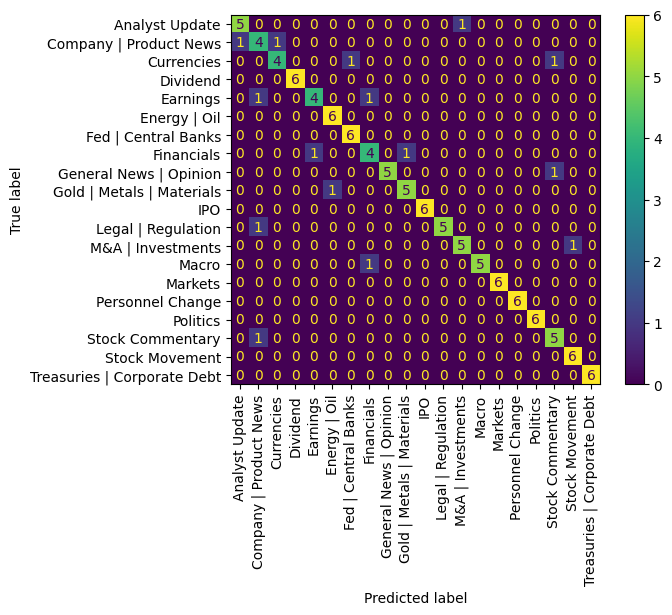

In [147]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=test_df['label'],
                      y_pred=predictions,
                      labels=model_pipeline.classes_
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model_pipeline.classes_
)
disp.plot(xticks_rotation=90)

## Analysis

In [148]:
model = model_pipeline.named_steps['classifier']
vectorizer = model_pipeline.named_steps['vectorizer']
classes = model.classes_

#### Vocabulary

In [149]:
vectorizer.vocabulary_

{'thursday': 19198,
 'biggest': 3396,
 'analyst': 2243,
 'call': 4164,
 'apple': 2425,
 'amazon': 2152,
 'tesla': 19046,
 'palantir': 14265,
 'docusign': 6647,
 'exxon': 7842,
 'amp': 2209,
 'buy': 4082,
 'la': 11393,
 'vega': 20216,
 'sand': 16823,
 'travel': 19506,
 'singapore': 17532,
 'build': 4000,
 'well': 20736,
 'fargo': 7937,
 'say': 16898,
 'piper': 14743,
 'sandler': 16828,
 'downgrade': 6731,
 'sell': 17139,
 'citing': 4818,
 'elevated': 7140,
 'risk': 16475,
 'amid': 2190,
 'ceo': 4525,
 'transition': 19483,
 'react': 15764,
 'latest': 11483,
 'earnings': 6935,
 'break': 3802,
 'next': 13357,
 'electric': 7119,
 'car': 4279,
 'maker': 12139,
 'netflix': 13296,
 'peer': 14482,
 'set': 17226,
 'return': 16324,
 'growth': 9241,
 'giving': 8938,
 'one': 13887,
 'stock': 18301,
 '120': 182,
 'upside': 20035,
 'barclays': 3097,
 'belief': 3271,
 'underperforming': 19842,
 'may': 12356,
 'surprise': 18612,
 'wall': 20570,
 'street': 18376,
 'bernstein': 3327,
 'upgrade': 20016,
 

In [150]:
keyword = 'gold-inflation'
if keyword in vectorizer.vocabulary_:
    print(keyword, ':', vectorizer.vocabulary_[keyword])
else:
    print(keyword, 'not found')

gold-inflation not found


In [151]:
len(vectorizer.vocabulary_)

21310

In [152]:
vectorizer.get_feature_names_out()

array(['00', '000', '000m', ..., 'åkerström', 'є0', 'є1'], dtype=object)

#### Weight

In [153]:
weights = pd.DataFrame(model.coef_.T,
                       columns=model.classes_,
                       index=vectorizer.get_feature_names_out()
)
weights

,Analyst Update,Company | Product News,Currencies,Dividend,Earnings,Energy | Oil,Fed | Central Banks,Financials,General News | Opinion,Gold | Metals | Materials,IPO,Legal | Regulation,M&A | Investments,Macro,Markets,Personnel Change,Politics,Stock Commentary,Stock Movement,Treasuries | Corporate Debt
00,-0.017422,0.081536,-0.154259,-0.047092,-0.079352,-0.131555,0.064416,-0.755019,-0.080410,-0.011930,-0.009850,-0.024614,-0.028422,0.490118,0.689018,-0.017902,-0.044395,-0.123142,0.390214,-0.189937
000,0.130523,0.246221,-0.282538,-0.075685,-0.363104,-0.212569,-0.282580,0.187571,-0.190146,0.618335,-0.073621,0.109681,-0.102599,0.142386,0.500356,-0.075880,-0.271469,0.047597,0.335349,-0.387830
000m,-0.000275,-0.000273,-0.000311,-0.000277,-0.000365,0.057178,-0.000625,-0.000287,-0.000274,-0.000276,-0.000274,-0.000269,-0.000275,-0.051668,-0.000277,-0.000271,-0.000275,-0.000281,-0.000278,-0.000347
000th,-0.000597,0.049184,-0.000805,-0.000276,-0.000399,-0.000396,-0.000967,-0.001137,-0.015432,-0.000524,-0.000306,-0.004608,-0.000560,-0.004308,-0.000525,-0.001477,-0.001202,-0.006154,-0.002474,-0.007037
000x,-0.005731,-0.009049,-0.000712,-0.000916,-0.001305,-0.001778,-0.001259,-0.001715,-0.023676,-0.000682,-0.000414,-0.001583,-0.006637,-0.003706,-0.021758,-0.001833,-0.005690,0.095241,-0.004894,-0.001901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyus,-0.001889,0.183632,-0.000650,-0.023210,-0.000481,-0.059935,-0.002013,-0.001468,-0.050843,-0.000420,-0.000390,-0.004060,-0.010864,-0.007102,-0.001495,-0.002912,-0.001173,-0.008016,-0.003711,-0.002998
zyversa,-0.011799,-0.024126,-0.003933,-0.004206,-0.003181,-0.004652,-0.004318,-0.007512,-0.027593,-0.002804,0.676928,-0.010728,-0.481084,-0.006289,-0.003489,-0.009862,-0.009043,-0.012728,-0.040823,-0.008758
åkerström,-0.000037,-0.000036,-0.000030,-0.000031,0.000715,-0.000031,-0.000030,-0.000080,-0.000030,-0.000035,-0.000032,-0.000029,-0.000031,-0.000031,-0.000035,-0.000035,-0.000029,-0.000075,-0.000045,-0.000032
є0,-0.000556,-0.001972,-0.000319,-0.000258,-0.000632,-0.000541,-0.000408,0.021920,-0.001652,-0.000240,-0.000210,-0.000817,-0.001305,-0.000679,-0.000282,-0.001243,-0.000882,-0.001709,-0.007627,-0.000588


In [154]:
# 1st top f1-score
weights.sort_values('Dividend', ascending=False)['Dividend'][:10]

,Dividend
dividend,6.124564
distribution,3.676792
declares,3.224921
announces,1.761654
quarterly,1.240488
monthly,1.001435
trust,0.998092
share,0.998068
fund,0.949778
reit,0.862405


In [155]:
# 2nd top f1-score
weights.sort_values('IPO', ascending=False)['IPO'][:10]

,IPO
ipo,6.476943
public,1.830717
spac,1.545628
go,1.389926
porsche,0.939757
share,0.938356
going,0.891675
kong,0.838454
hong,0.838454
deal,0.822004


In [156]:
#2nd least f1-score
weights.sort_values('Stock Movement', ascending=False)['Stock Movement'][:10]

,Stock Movement
pre,5.422524
share,2.740728
gain,2.136688
jump,2.129161
stock,2.024256
bitcoin,1.816910
gainer,1.736333
slide,1.685681
tumble,1.585456
slip,1.565486


In [157]:
#1st least f1-score
weights.sort_values('Gold | Metals | Materials', ascending=False)['Gold | Metals | Materials'][:10]

,Gold | Metals | Materials
gold,5.583079
metal,3.410096
copper,2.738782
comdx,1.878066
settlement,1.776277
dollar,1.483857
silver,1.352011
nickel,1.328173
trading,1.226544
price,1.136753


In [158]:
top_10_list = []
for cls in classes:
    top_words = weights[cls].sort_values(ascending=False).head(10).index.tolist()
    top_10_list.append(top_words)

# สร้างตารางสรุป (Columns = ชื่อคลาส, Rows = อันดับ 1-10)
summary_table = pd.DataFrame(top_10_list, index=classes).T
summary_table.index = [f"Top {i+1}" for i in range(10)]

print("--- Top 10 Important Words per Class ---")
print(summary_table)

--- Top 10 Important Words per Class ---
       Analyst Update Company | Product News Currencies      Dividend  \
Top 1       downgrade                 launch     dollar      dividend   
Top 2         analyst                expands       euro  distribution   
Top 3      downgraded               receives        usd      declares   
Top 4         upgrade            partnership      rupee     announces   
Top 5        barclays           announcement   currency     quarterly   
Top 6          rating             introduces      rally       monthly   
Top 7        research                  award         89         trust   
Top 8             cut               employee        yen         share   
Top 9          target                 hiring       usea          fund   
Top 10         citing                twitter         70          reit   

          Earnings Energy | Oil Fed | Central Banks Financials  \
Top 1     earnings          oil                 fed    revenue   
Top 2       result     

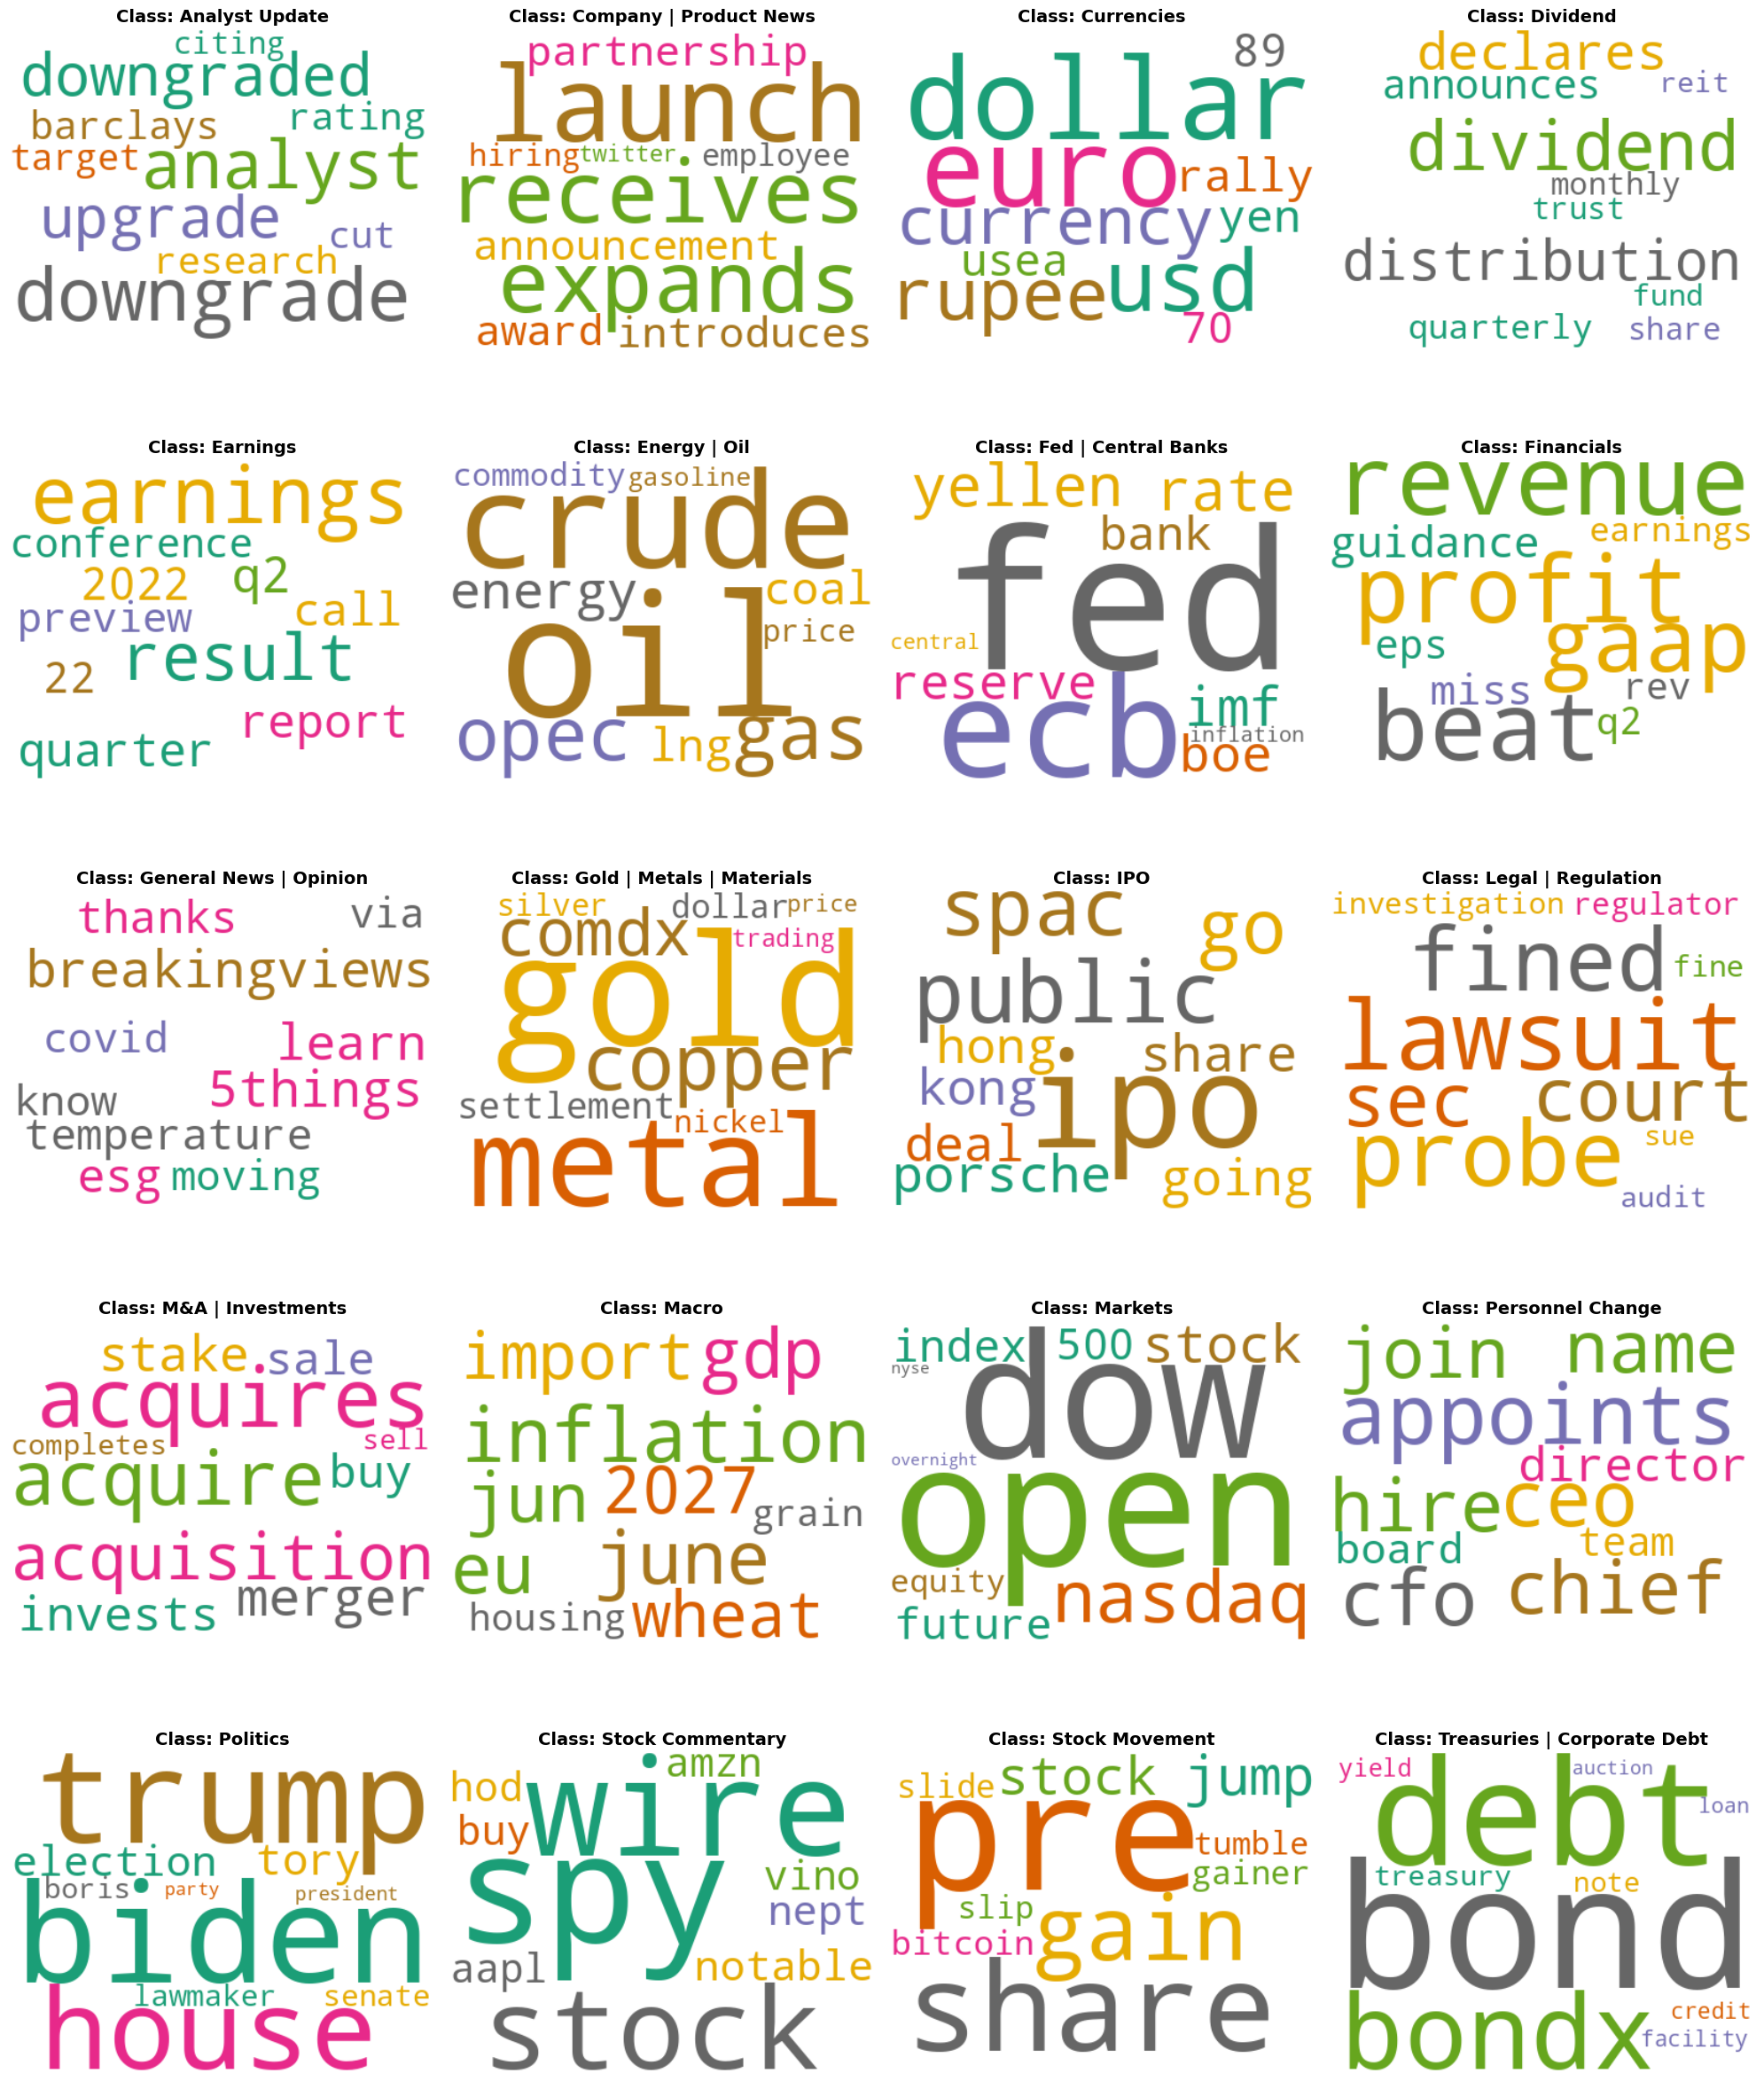

In [159]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math

# 1. ตั้งค่าการแสดงผล (5 แถว x 4 คลาส = 20 คลาสพอดี)
cols = 4
rows = math.ceil(len(classes) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 25))
axes = axes.flatten()

# 2. วนลูปสร้าง Word Cloud ทีละคลาส
for i, cls in enumerate(classes):
    # ดึง Top 10 weights ที่เป็นบวกของคลาสนั้น
    top_10_weights = weights[cls].sort_values(ascending=False).head(10).to_dict()
    
    # สร้าง Word Cloud
    wc = WordCloud(
        width=400, 
        height=300, 
        background_color='white',
        colormap='Dark2',
        prefer_horizontal=1.0 # เน้นให้อ่านง่ายในรูปเล็ก
    )
    wc.generate_from_frequencies(top_10_weights)
    
    # แสดงผลใน Subplot
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"Class: {cls}", fontsize=14, fontweight='bold')
    axes[i].axis('off')

# 3. ลบพื้นที่ว่าง (ถ้ามี) และแสดงรูป
plt.tight_layout()
plt.show()

#### Bias

In [160]:
pd.DataFrame(model.intercept_, index=model.classes_)

,0
Analyst Update,0.118721
Company | Product News,1.934974
Currencies,-0.877807
Dividend,-1.418345
Earnings,-1.429263
Energy | Oil,-0.423096
Fed | Central Banks,-0.180452
Financials,-0.007929
General News | Opinion,1.750458
Gold | Metals | Materials,-1.593114


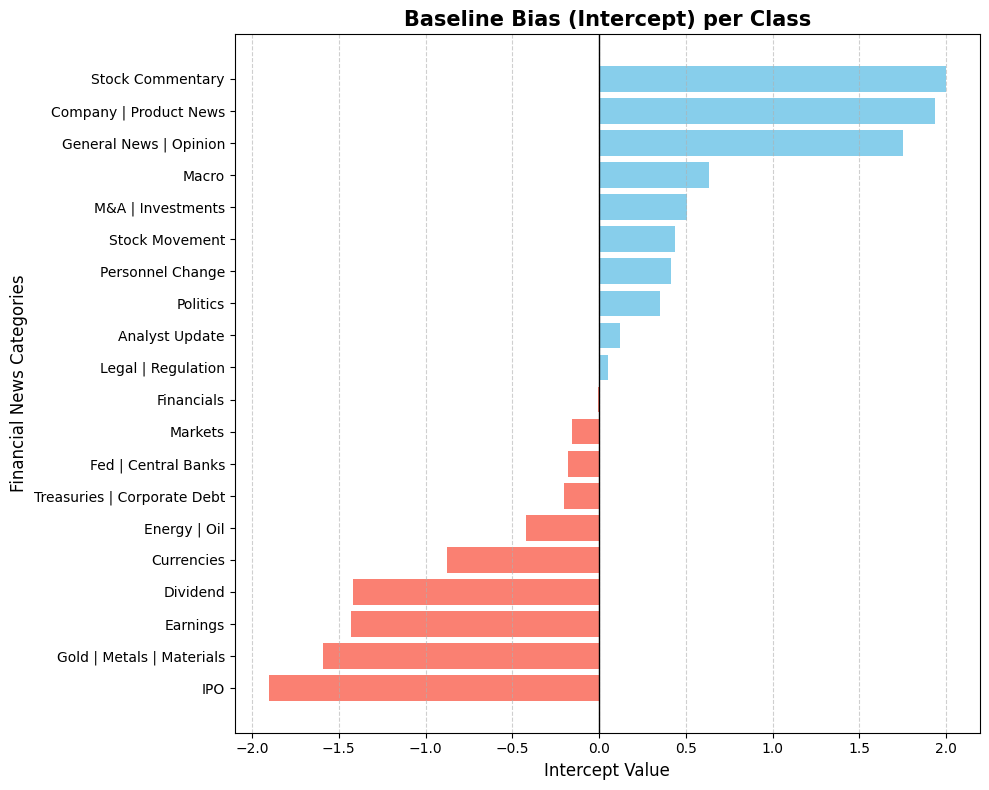

In [161]:
import matplotlib.pyplot as plt

# 1. ดึงค่า Intercept และ Class Names ออกมาจากโมเดล
clf = model_pipeline.named_steps['classifier']
intercepts = clf.intercept_
classes = clf.classes_

# 2. สร้าง DataFrame เพื่อให้จัดการข้อมูลและเรียงลำดับง่ายขึ้น
bias_df = pd.DataFrame({
    'Class': classes,
    'Bias_Score': intercepts
}).sort_values(by='Bias_Score', ascending=True) # เรียงจากน้อยไปมากเพื่อให้ barh แสดงตัวมากสุดไว้บนสุด

# 3. พลอตกราฟแท่งแนวนอน
plt.figure(figsize=(10, 8))
colors = ['salmon' if x < 0 else 'skyblue' for x in bias_df['Bias_Score']] # แยกสีให้ดูง่าย: ลบ=แดง, บวก=ฟ้า

plt.barh(bias_df['Class'], bias_df['Bias_Score'], color=colors)

# 4. ตกแต่งกราฟ
plt.axvline(x=0, color='black', linestyle='-', linewidth=1) # เส้นแบ่งที่จุด 0
plt.title('Baseline Bias (Intercept) per Class', fontsize=15, fontweight='bold')
plt.xlabel('Intercept Value', fontsize=12)
plt.ylabel('Financial News Categories', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Zero-shot LLM Classifier

In [105]:
import os
from dotenv import load_dotenv
from getpass import getpass

# Load variables from .env file
load_dotenv()

# Access the variables
TYPHOON_API_KEY = os.getenv("TYPHOON_API_KEY")
if TYPHOON_API_KEY is None:
    TYPHOON_API_KEY = getpass("Enter Typhoon API Key:")

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
if GOOGLE_API_KEY is None:
    GOOGLE_API_KEY = getpass("Enter Google API Key:")

In [106]:
import re

def clean_text(text):
    text = re.sub(r'\|', '', text)

    return text

## Typhoon

In [107]:
from openai import OpenAI

def analyze_topic_typhoon(text):

    client = OpenAI(
        api_key=TYPHOON_API_KEY,
        base_url='https://api.opentyphoon.ai/v1'
    )

    messages = [
        {
            "role": "system", 
            "content": """You are an expert Financial News Editor and Data Classifier. 
            Classify the provided financial news headline list from user's prompt into exactly one of the following 20 categories: 
            
            'Analyst Update', 
            'Company | Product News',
            'General News | Opinion', 
            'Currencies', 
            'Dividend', 
            'Earnings',
            'Energy | Oil', 
            'Fed | Central Banks', 
            'Financials',
            'Gold | Metals | Materials', 
            'IPO', 
            'Legal | Regulation',
            'M&A | Investments', 
            'Macro', 
            'Markets', 
            'Personnel Change',
            'Politics', 
            'Stock Commentary', 
            'Stock Movement',
            'Treasuries | Corporate Debt'

            Each of output must be label string only.

            Given response as json array format
            """
        },
        {
            "role": "User",
            "content": text
        }
    ]

    response = client.chat.completions.create(
        model="typhoon-v2.5-30b-a3b-instruct",
        messages=messages,
    )

    return response.choices[0].message.content

In [110]:
test_df.iloc[0]

,0
text,Analyst call of the day for @CNBCPro subscribe...
label,Analyst Update


In [141]:
text = clean_text(test_df.iloc[0]['text'])
print(text)
print(analyze_topic_typhoon([text]))

Morgan Stanley's Huberty sees Apple earnings miss, but says buy on any pullback  


InternalServerError: Error code: 500 - {'detail': "Can't process the request, please try again later."}

## Gemini

In [121]:
test_df['text'].info()

<class 'pandas.core.series.Series'>
Index: 120 entries, 4 to 4087
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
120 non-null    object
dtypes: object(1)
memory usage: 1.9+ KB


In [122]:
from google import genai
from google.genai import types

def analyze_topic_gemini(text):

    client = genai.Client(
        api_key=GOOGLE_API_KEY,
    )

    response = client.models.generate_content(
        model="gemini-3-flash-preview",
        config=types.GenerateContentConfig(
            system_instruction="""You are an expert Financial News Editor and Data Classifier. 
            Classify the provided financial news headline list from user's prompt into exactly one of the following 20 categories: 
            
            'Analyst Update', 
            'Company | Product News',
            'General News | Opinion', 
            'Currencies', 
            'Dividend', 
            'Earnings',
            'Energy | Oil', 
            'Fed | Central Banks', 
            'Financials',
            'Gold | Metals | Materials', 
            'IPO', 
            'Legal | Regulation',
            'M&A | Investments', 
            'Macro', 
            'Markets', 
            'Personnel Change',
            'Politics', 
            'Stock Commentary', 
            'Stock Movement',
            'Treasuries | Corporate Debt'

            Each of output must be label string only.

            Given response as json array format
            """
        ),
        contents=text
    )

    return response.text

In [125]:
text = [clean_text(test_df.iloc[0]['text']), clean_text(test_df.iloc[1]['text'])]
print(text)


["Morgan Stanley's Huberty sees Apple earnings miss, but says buy on any pullback  ", 'Investors warn of looming downgrades to US and European earnings forecasts  ']


In [126]:
print(analyze_topic_gemini([text]))

[
  "Analyst Update",
  "Earnings"
]


In [127]:
test_df['text'].tolist()

["Morgan Stanley's Huberty sees Apple earnings miss, but says buy on any pullback  ",
 'Investors warn of looming downgrades to US and European earnings forecasts  ',
 'Wells Fargo downgrades Gap, says it cannot recommend buying the apparel retailer after CEO exit  ',
 'Analyst call of the day for @CNBCPro subscribers: Goldman Sachs reiterates Exxon as buy and says it’s bullish heading into earnings next week.  Subscribe to see the analyst calls of the day curated by CNBC Pro.  ',
 '$ACLX $TSVT $BMY - Arcellx named new buy at Canaccord Genuity on multiple myeloma candidate  ',
 'Instacart investor Capital Group cut its valuation to $14.7 billion, far below the online grocery-delivery firm’s own calculation of $24 billion  ',
 '$NVAX: Novavax: US CDC Advisory Committee voted unanimously to recommend the use of the Novavax COVID-19 vaccine,...  ',
 'Epoch Concepts Announces Epoch Axis, a New Zero-Trust-Based Remote Access Solution for Energy Companies  https://t.co/GkXea4auUO  ',
 'Comet

In [128]:
gemini_preds = analyze_topic_gemini(test_df['text'].tolist())

In [129]:
print(gemini_preds)

```json
[
  "Analyst Update",
  "Earnings",
  "Analyst Update",
  "Analyst Update",
  "Analyst Update",
  "Analyst Update",
  "M&A | Investments",
  "Company | Product News",
  "Company | Product News",
  "Company | Product News",
  "Company | Product News",
  "Company | Product News",
  "Analyst Update",
  "Currencies",
  "Currencies",
  "Currencies",
  "Currencies",
  "Currencies",
  "Dividend",
  "Dividend",
  "Dividend",
  "Dividend",
  "Dividend",
  "Dividend",
  "Earnings",
  "Earnings",
  "Earnings",
  "Earnings",
  "Earnings",
  "Earnings",
  "Energy | Oil",
  "Energy | Oil",
  "Energy | Oil",
  "Energy | Oil",
  "Energy | Oil",
  "Energy | Oil",
  "Fed | Central Banks",
  "Fed | Central Banks",
  "Fed | Central Banks",
  "Fed | Central Banks",
  "Fed | Central Banks",
  "Fed | Central Banks",
  "Earnings",
  "Earnings",
  "Earnings",
  "Earnings",
  "Earnings",
  "Earnings",
  "General News | Opinion",
  "General News | Opinion",
  "General News | Opinion",
  "General News | O

In [130]:
import json, re

s = gemini_preds
m = re.search(r"```(?:json)?\s*(\[.*\])\s*```", s, re.S)
if m:
    test_preds_gemini = json.loads(m.group(1))
else:
    start = s.find('[')
    end = s.rfind(']')
    test_preds_gemini = json.loads(s[start:end+1]) if start != -1 and end != -1 else json.loads(s)

# optional quick check
print(type(test_preds_gemini), len(test_preds_gemini))

<class 'list'> 120


In [131]:
from sklearn.metrics import classification_report

print(classification_report(test_preds_gemini, test_df['label']))

                             precision    recall  f1-score   support

             Analyst Update       0.83      0.83      0.83         6
     Company | Product News       0.83      1.00      0.91         5
                 Currencies       0.83      1.00      0.91         5
                   Dividend       1.00      1.00      1.00         6
                   Earnings       1.00      0.46      0.63        13
               Energy | Oil       1.00      1.00      1.00         6
        Fed | Central Banks       1.00      1.00      1.00         6
                 Financials       0.00      0.00      0.00         0
     General News | Opinion       1.00      1.00      1.00         6
  Gold | Metals | Materials       1.00      1.00      1.00         6
                        IPO       1.00      1.00      1.00         6
         Legal | Regulation       1.00      1.00      1.00         6
          M&A | Investments       1.00      0.86      0.92         7
                      Macro      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


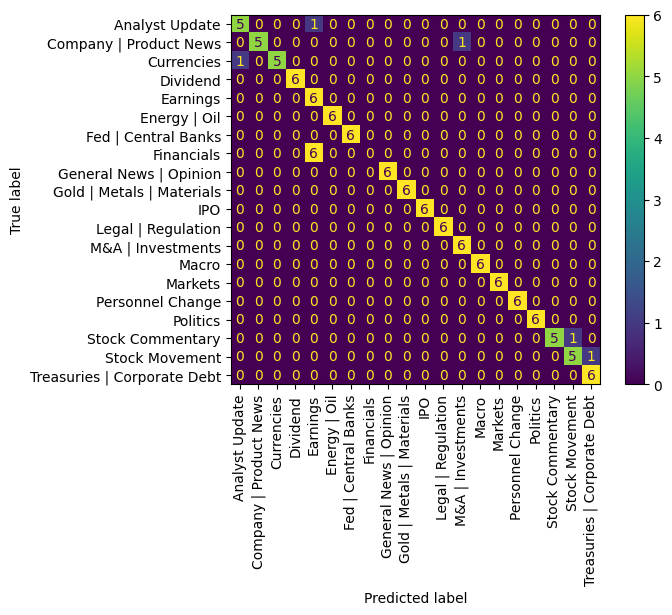

In [162]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=test_df['label'],
                      y_pred=test_preds_gemini,
                      labels=model_pipeline.classes_
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model_pipeline.classes_
)
disp.plot(xticks_rotation=90)

### Analysis

In [132]:
gemini_analyse_df = test_df
gemini_analyse_df['gemini_preds'] = test_preds_gemini

In [140]:
gemini_analyse_df[gemini_analyse_df['gemini_preds']=='Earnings']

,text,label,gemini_preds
63,Investors warn of looming downgrades to US and...,Analyst Update,Earnings
1080,Avalara to Announce Second Quarter 2022 Financ...,Earnings,Earnings
1062,$SUMRX: Earnings/Guidance Movers,Earnings,Earnings
1208,"$AAPL - Apple likely to meet Q3 results, but a...",Earnings,Earnings
1265,$USB $USB.PH $USB.PA - U.S. Bancorp (USB) CEO ...,Earnings,Earnings
1293,$IBM | IBM Q2 22 Earnings - Q2 Operating EPS...,Earnings,Earnings
1255,"$BAC - Bank of America: Mixed Q2 Earnings, Gre...",Earnings,Earnings
1763,$WFC - Wells Fargo Q2 earnings decline hurt by...,Financials,Earnings
1766,$UNH - UnitedHealth Non-GAAP EPS of $5.57 beat...,Financials,Earnings
1799,"ASML, Europe’s largest semiconductor equipment...",Financials,Earnings
